# Computer Vision - P4

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments and answers need to be in **English**.

- The deliverable must be a file named **P4_Student1_Student2.zip** that includes:
    - The notebook P4_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Campus Virtual): November 22th, 23:00 h** 

==============================================================================================
## Descriptors extraction for object detection, based on template matching, ORB, and HOG
==============================================================================================

The main topics of Laboratory 4 are:

    4.1) SSD and Normalized Cross-correlation for template matching

    4.2) HOG image descriptor for object (person) detection

    4.3) Recognition by correspondance, based on feature extraction (ORB)

In order to complete this practicum, the following concepts need to be understood: template matching, feature localization (Harris, Censure), feature descriptor (HOG,ORB, Sift) methods.

It is highly recommendable to structure the code in functions in order to reuse code for different tests and images and make it shorter and more readable. Specially the visualization commands should be encapsulated in separate functions.

In [1]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

def plot_row(images, titles, figsize, gray=False):
    _, axs = plt.subplots(ncols=len(images), figsize=figsize)
    for i in range(len(images)):
        axs[i].imshow(images[i], cmap='gray' if gray else None)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def visualize(figsize, gray_locations=None, contrast=None, *args):

    if len(args) == 1:
        visualize_single(figsize, args[0], gray_locations, contrast)
        return 0

    fig, axs = plt.subplots(nrows=len(args[0]), ncols=len(args), figsize=figsize)

    for i, entries in enumerate(args):
        for j, entry in enumerate(entries):
            image, title = entry
            if gray_locations is not None:
                if (j, i) in gray_locations:
                    if contrast is None:
                        axs[j][i].imshow(image, cmap='gray')
                    else:
                        axs[j][i].imshow(image, cmap='gray', vmin=contrast[0], vmax=contrast[1])
                else:
                    if contrast is None:
                        axs[j][i].imshow(image, cmap='gray')
                    else:
                        axs[j][i].imshow(image, cmap='gray', vmin=contrast[0], vmax=contrast[1])
            else:
                axs[j][i].imshow(image)
            axs[j][i].title.set_text(title)
            axs[j][i].axis('off')

    plt.show()

def visualize_single(figsize, images, gray_locations=None, contrast=False):
    fig, axs = plt.subplots(ncols=len(images), figsize=figsize)

    for i, entry in enumerate(images):
        image, title = entry
        if gray_locations is not None:
            if i in gray_locations:
                if contrast is None:
                    axs[i].imshow(image, cmap='gray')
                else:
                    axs[i].imshow(image, cmap='gray', vmin=contrast[0], vmax=contrast[1])
            else:
                if contrast is None:
                    axs[i].imshow(image, cmap='gray')
                else:
                    axs[i].imshow(image, cmap='gray', vmin=contrast[0], vmax=contrast[1])
        else:
            axs[i].imshow(image)
        axs[i].title.set_text(title)
        axs[i].axis('off')

    plt.show()

# 1 Template matching

**1.1** Given the image 'einstein.png' and the template image 'eye.png', detect the location of the template in the image comparing the use of:
- SSD distance (hint: norm() in numpy.linalg).
- normalized cross-correlation (hint: match_template() of skimage.feature).

Don't forget to normalize the images (having pixel values between [0,1]) before comparing them.

In [184]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

def plot_row(images, titles, figsize, gray=False):
    _, axs = plt.subplots(ncols=len(images), figsize=figsize)
    for i in range(len(images)):
        axs[i].imshow(images[i], cmap='gray' if gray else None)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

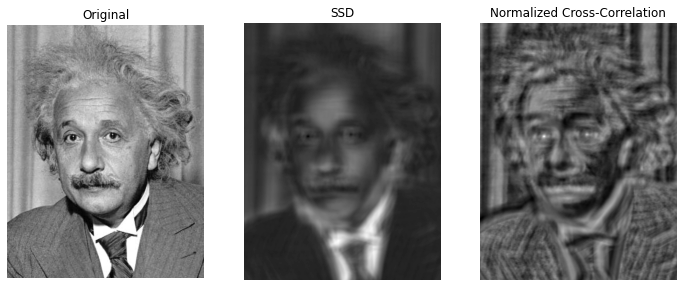

In [242]:
from scipy.signal import correlate
from skimage.feature import match_template

# Normal sliding window
def ssd_slow(image, template):
    image_ssd = np.zeros(np.array(image.shape) - template.shape + 1)
    k, l = template.shape
    for i in range(image_ssd.shape[0]):
        for j in range(image_ssd.shape[1]):
            image_ssd[i, j] = np.sum(np.square(template - image[i:i+k, j:j+l]))
    return image_ssd

# Fast sliding window, from "(a-b)^2 = a^2 + b^2 - 2ab" we use the right side
def ssd(image, template):
    a_sq = correlate(np.square(image), np.ones_like(template), mode='valid')
    b_sq = np.sum(np.square(template))
    a_b = correlate(image, template, mode='valid')
    return a_sq + b_sq - 2 * a_b

def normalize_image(image):
    img_max, img_min = image.max(), image.min()
    return (image - img_min) / (img_max - img_min)

einstein = io.imread('images/einstein.png', as_gray=True)
eye = io.imread('images/eye.png', as_gray=True)

slow_einstein_ssd = normalize_image(ssd_slow(einstein, eye))
einstein_ssd = normalize_image(ssd(einstein, eye))
assert np.allclose(slow_einstein_ssd, einstein_ssd)

einstein_ncc = normalize_image(match_template(einstein, eye))

plot_row([einstein, einstein_ssd, einstein_ncc], ['Original', 'SSD', 'Normalized Cross-Correlation'], \
    figsize=(12, 7), gray=True)

Create a function for template matching applying SSD distance and normalized cross-correlation and display the results in the following format:
    
<img src="images_notebook/tm.png">

**Use titles in all figures to understand what is being displayed.**

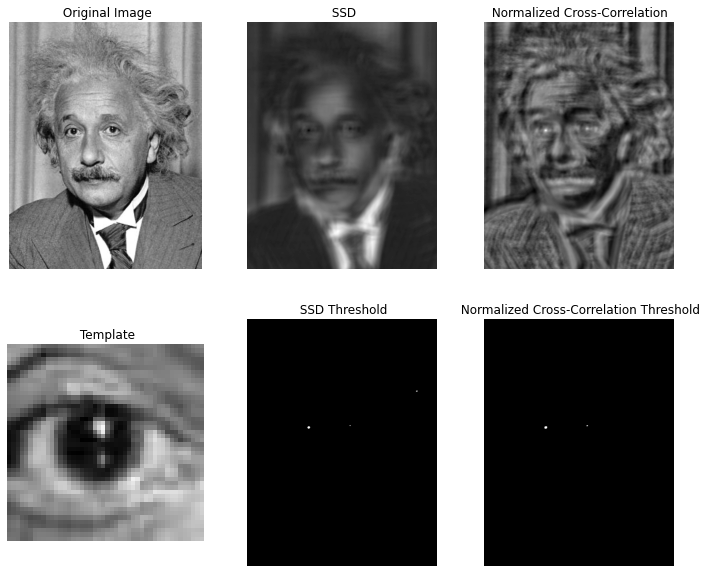

In [227]:
def match_template_methods_comparison(image, template, threshold_ssd, threshold_ncc, auto=False, title=''):

    image_ssd = ssd(image, template)
    image_ncc = match_template(image, template)

    # Probably el threshold s'ha d'aplicar abans de normalitzar la imatge!!
    if auto:
        threshold_ssd = np.quantile(image_ssd, 0.00015)
        threshold_ncc = np.quantile(image_ncc, 0.99985)

    match_ssd = image_ssd < threshold_ssd
    match_ncc = image_ncc > threshold_ncc

    originals = [(image, title + ' Original Image'), (template, title + ' Template')]
    ssd_detection = [(normalize_image(image_ssd), title + ' SSD'), (match_ssd, title + ' SSD Threshold')]
    ncc_detection = [(normalize_image(image_ncc), title + ' Normalized Cross-Correlation'), (match_ncc, title + \
        ' Normalized Cross-Correlation Threshold')]

    visualize((12, 10), [(i, j) for i in range(2) for j in range(3)], (0, 1), originals, ssd_detection, ncc_detection)

a = match_template_methods_comparison(einstein, eye, 70, 0.55, auto=True)

**1.2** How does the result of the template matching change if the image changes its contrast (for example if you make it clearer or darker)? 

Similarly to the previous case, please, visualize the euclidean distance and normalized cross-correlation images as well as the binarized (thresholded) images in the two cases.

**Note:** Use titles of the figures to explain what is displayed.


Read `einstein_br.png` and display the results on this image, using `eye.png` as template:

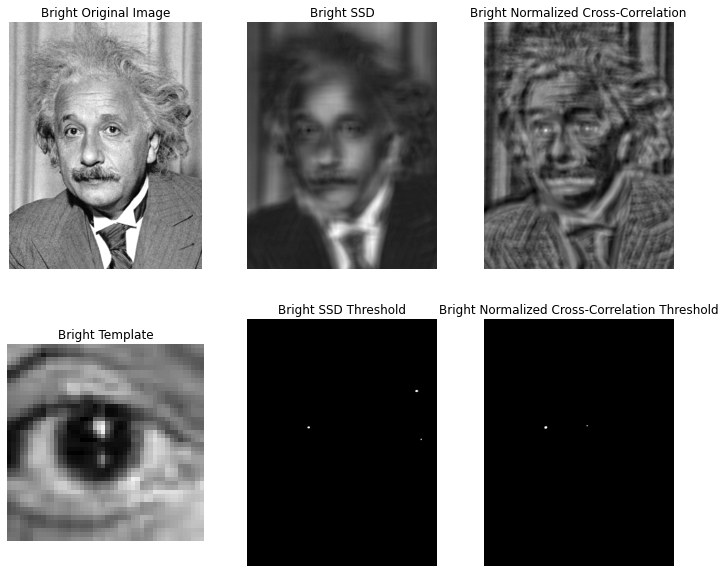

In [215]:
from skimage import img_as_float

einstein_br = img_as_float(io.imread('images/einstein_br.png'))

match_template_methods_comparison(einstein_br, eye, 76, 0.55, 'Bright')

Print the minimum SSD and the maximum Normalized Cross-Correlation (NCC)

In [10]:
# Without normalization between 0 and 1
print('Minimum SSD:', ssd(einstein_br, eye).min())
print('Maximum NCC:', match_template(einstein_br, eye).max())

Minimum SSD: 9.423998647352846
Maximum NCC: 0.9768232838639569


**1.3** Read `einstein_mask.png` and display the results on this image, using the `eye.png` template:

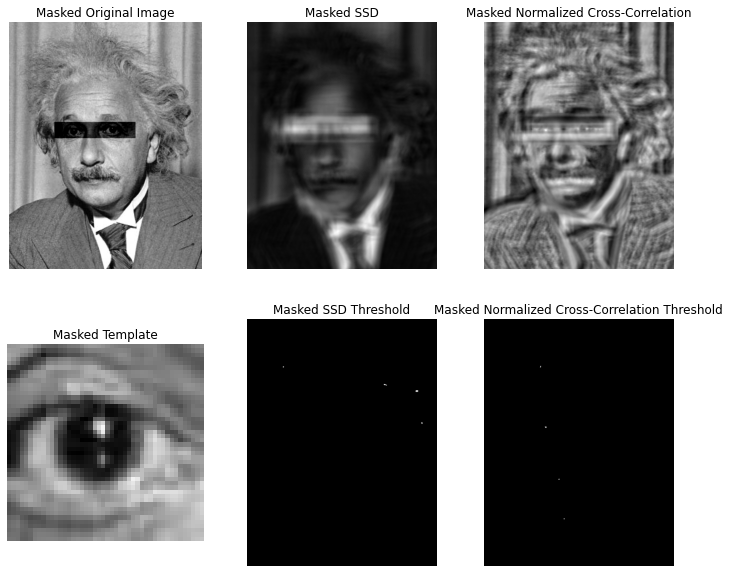

In [212]:
einstein_mask = img_as_float(io.imread('images/einstein_mask.png'))

match_template_methods_comparison(einstein_mask, eye, 75, 0.51, 'Masked')

Print the minimum SSD and the maximum NCC

In [20]:
print('Minimum SSD:', ssd(einstein_mask, eye).min())
print('Maximum NCC:', match_template(einstein_mask, eye).max())

Minimum SSD: 68.43652441368715
Maximum NCC: 0.616636273933732


What are the distances between the template and the image around the eyes of the image? 

In [ ]:
# Your solution here

Comment the template matching process:
* Is the algorithms affected by contrast changes in the image?
* How do metrics (i.e. minimum euclidean distance and maximum NCC) change in all previous cases? Is there a big difference among these values?
* What parameters it has and which measure for image comparisons works better.

In [ ]:
# Your solution here

**1.4** How does the result of the template matching change if instead the template is the one that changes its contrast (for example if you make it clearer or darker)? To this purpose, use the `eye_br.png` template.

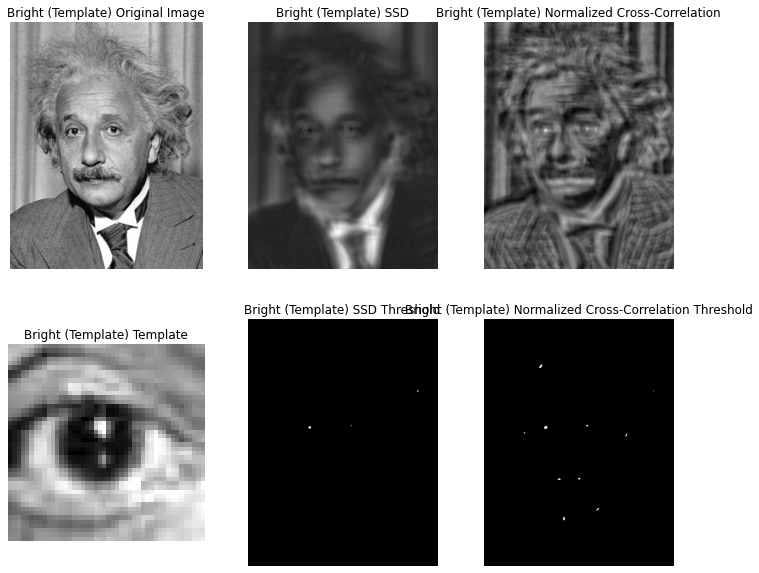

In [21]:
eye_br = img_as_float(io.imread('images/eye_br.png'))

match_template_methods_comparison(einstein, eye_br, 0.11, 0.33, 'Bright (Template)')

Check how the result changes if the template is rotated.

Visualize the template and its rotation by 2º, 5º, 10º, 15º and 20º. Obtain again the template matching using the Euclidean distance and normalized cross-correlation.

**Help:** use the function rotate() in skimage.transform

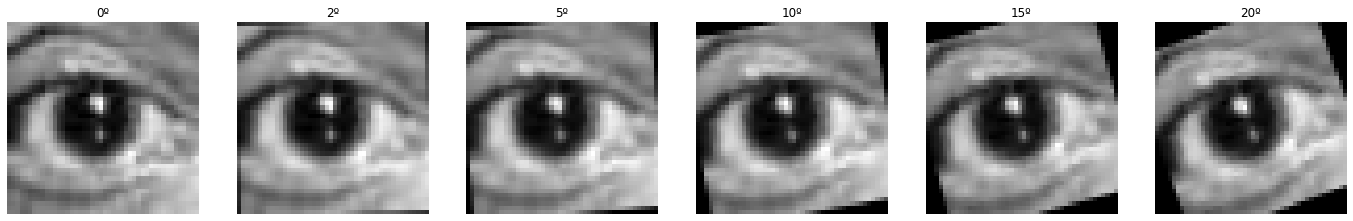

0

In [66]:
from skimage.transform import rotate

rotations = [(eye, '0º'), (rotate(eye, 2), '2º'), (rotate(eye, 5), '5º'), (rotate(eye, 10), '10º'), (rotate(eye, 15), '15º'), (rotate(eye, 20), '20º')]
visualize((24, 18), [i for i in range(6)], None, rotations)

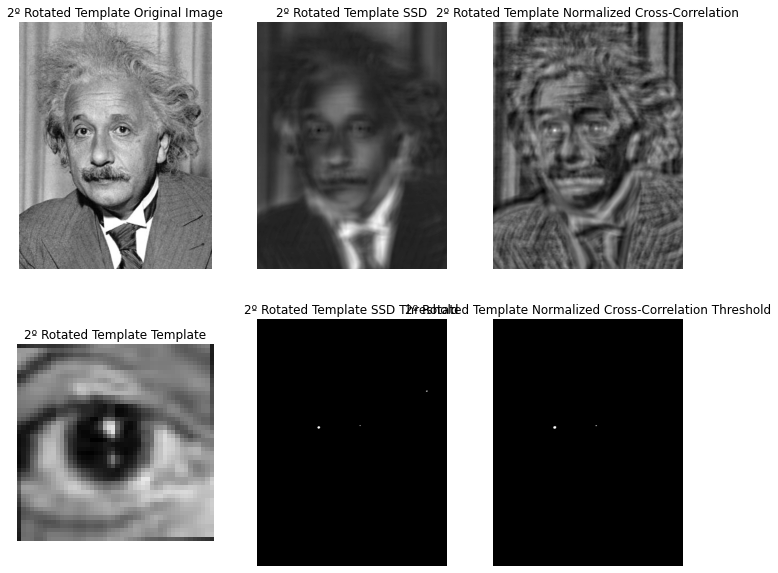

In [228]:
match_template_methods_comparison(einstein, rotate(eye, 2), 50, 0.5, True, '2º Rotated Template')

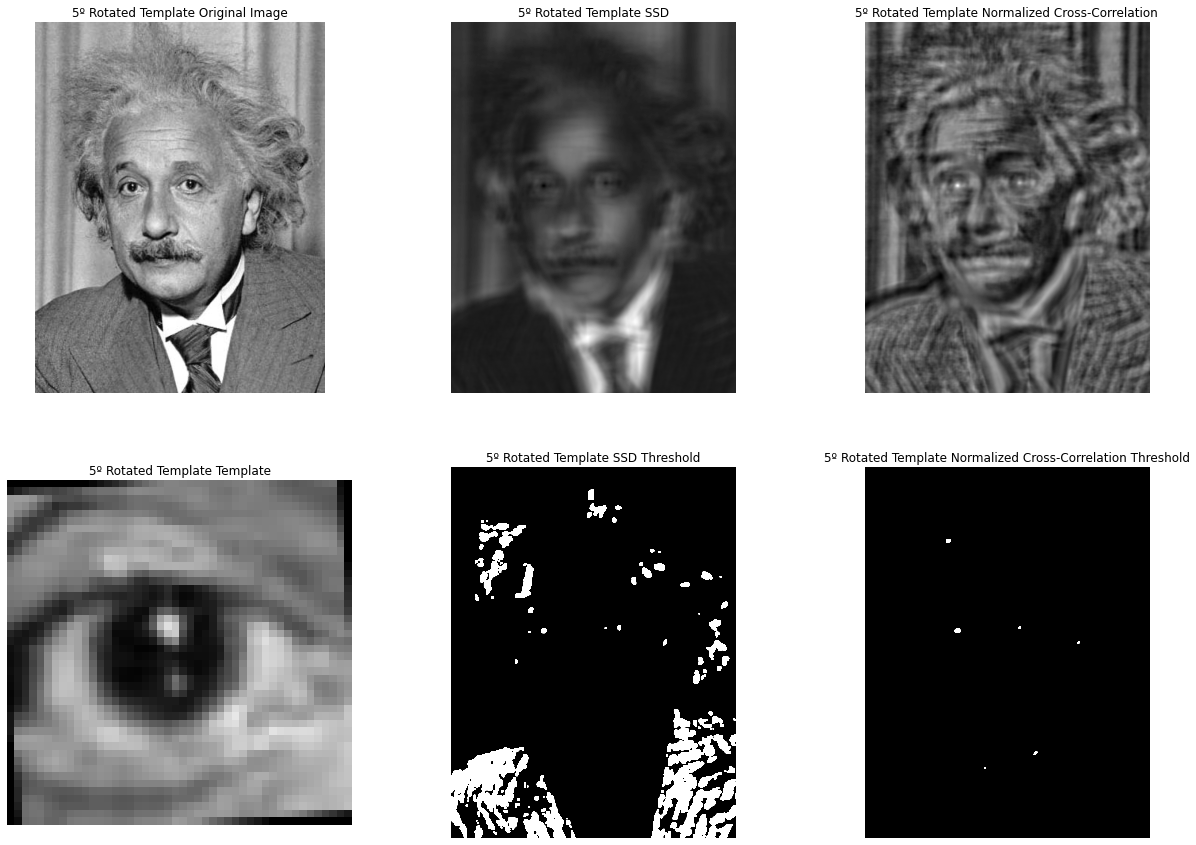

In [68]:
match_template_methods_comparison(einstein, rotate(eye, 5), 1e-1 * 1.1, 1e-1 * 3, '5º Rotated Template')

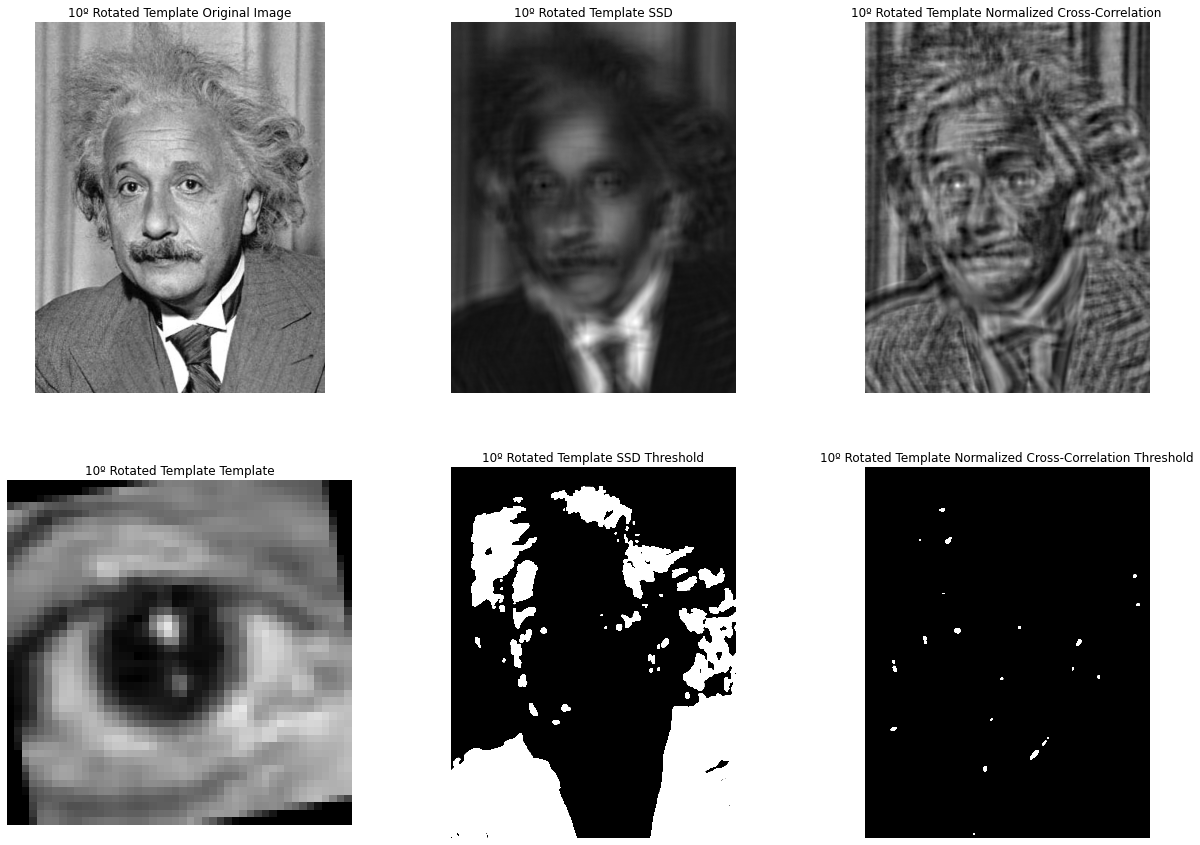

In [69]:
match_template_methods_comparison(einstein, rotate(eye, 10), 1e-1 * 1.1, 1e-1 * 3, '10º Rotated Template')

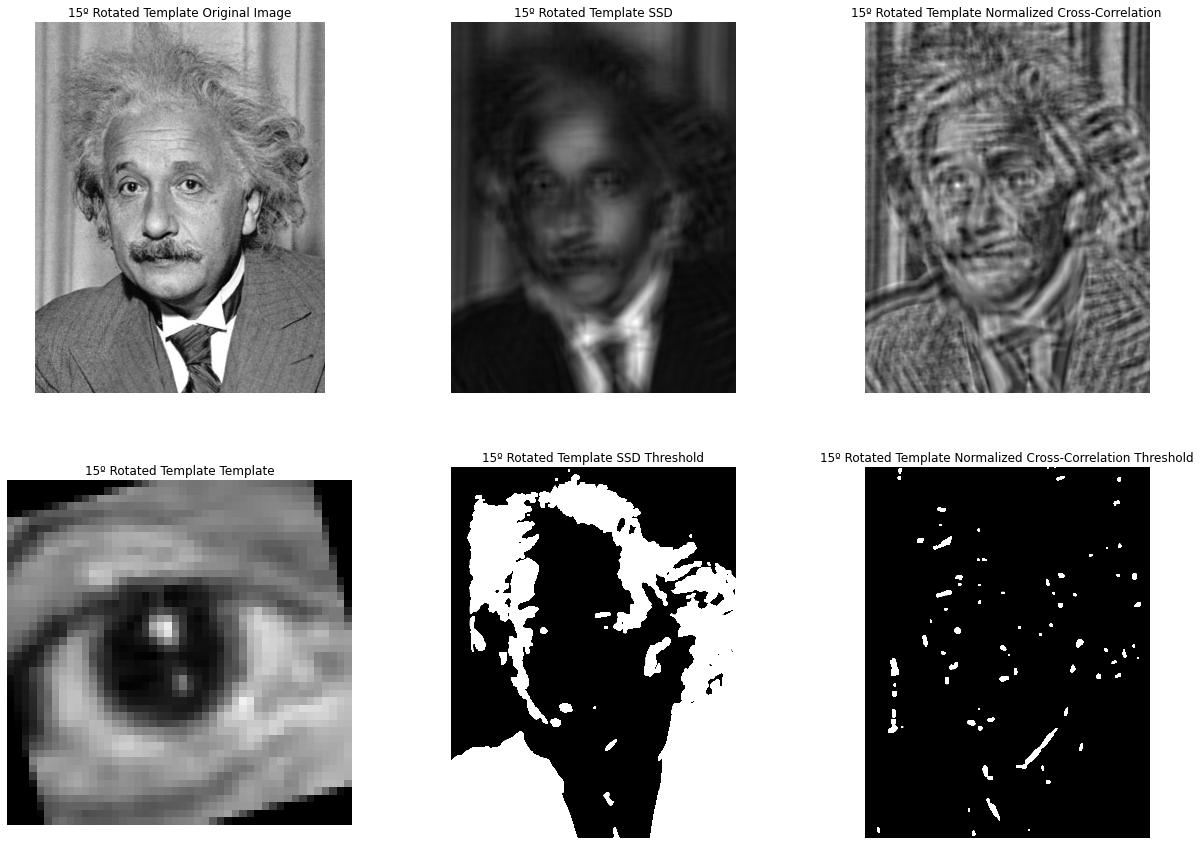

In [70]:
match_template_methods_comparison(einstein, rotate(eye, 15), 1e-1 * 1.1, 1e-1 * 3, '15º Rotated Template')

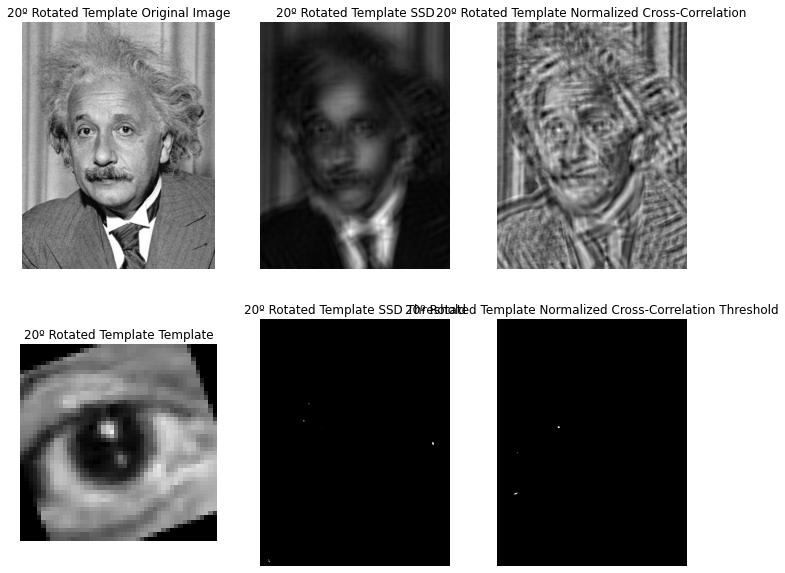

In [244]:
match_template_methods_comparison(einstein, rotate(eye, 20), 1e-1 * 1.1, 1e-1 * 3, True, '20º Rotated Template')

Comment the template matching process:
* Please, explain briefly the algorithm, including advantages and disadvantage
* Is the algorithms affected by contrast changes in the tempate image?
* What parameters it has and which measure for image comparisons works better.

In [ ]:
# Your solution here

# 2 Histogram of Oriented Gradients

In this section we will treat the following topic: HOG image descriptor. Application to person detection.

The Histogram of Oriented Gradients (HOG) feature descriptor is classical image descriptor for object detection.

Given the image `person_template.bmp` and the folder `/images/TestPersonImages/`, apply the HOG descriptor in order to detect where there is a person in the images. To this purpose, apply the "sliding window" technique. We use images from GRAZ 01 data from [INRIA datasets](http://pascal.inrialpes.fr/data/human/).

**2.1.** Read the template (`person_template.bmp`), obtain its HOG descriptor (with the optimal parameters) and visualize it.

Help: the HOG detector function is in the skimage.feature library ([Help](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py)).

Predicted n_blocks_row, n_blocks_col: [14.125  4.125]
n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient: (4536,)


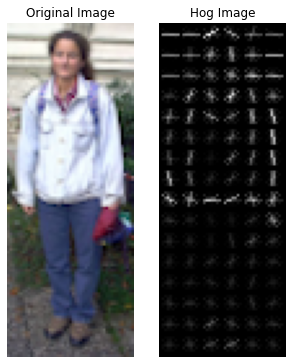

In [22]:
from skimage.feature import hog
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgba2rgb, rgb2gray
import numpy as np

person_template = io.imread('images/person_template.bmp')

person_template_hog_split, vis = hog(rgb2gray(rgba2rgb(person_template)), visualize=True)
person_template_hog = person_template_hog_split.flatten()

print('Predicted n_blocks_row, n_blocks_col:', np.array(person_template.shape[:2]) / [8, 8] - 2)
print('n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient:', person_template_hog_split.shape)

result = [(person_template, 'Original Image'), (vis, 'Hog Image')]

visualize_single((5, 10), result, [1], None)

**2.2.** Apply the HOG descriptor on the complete set of images for person detection.

a) Read images from the folder "TestPersonImages", slide a window on each image, obtain the HOG descriptor and compare to the HOG descriptor of the person template. 

b) Visualize the location in the image that is the most similar to the person template using the distance between the template and test image descriptors.

Display the results of every person detection following this format:

<img src="images_notebook/hog.png">

In [23]:
import tqdm
import matplotlib.patches as patches

test_person_images = io.ImageCollection('images/TestPersonImages/*.bmp')

def mark(image, i, j, n, m):
    mask = np.zeros(image.shape[:2], dtype='bool')
    mask[i:i+n, j] = 1
    mask[i:i+n, j+m] = 1
    mask[i, j:j+m] = 1
    mask[i+n, j:j+m] = 1
    marked_image = image.copy()
    marked_image[mask] = (255, 0, 0)
    return marked_image

def hog_comparison(image_collection, template, template_desc, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):

    plt.imshow(template)
    plt.axis('off')
    plt.title(template_desc + ' Template')
    plt.show()

    template_hog_split = hog(rgb2gray(rgba2rgb(template)), orientations, pixels_per_cell, cells_per_block)
    template_hog = template_hog_split.flatten()

    n, m = template.shape[:2]
    for image in tqdm.tqdm(image_collection):
        gray_image = rgb2gray(image)
        min_distance = float('inf')
        best_i, best_j = 0, 0
        for i in range(image.shape[0] - n):
            for j in range(image.shape[1] - m):
                sub_image = gray_image[i:i+n, j:j+m]
                sub_image_hog = hog(sub_image, orientations, pixels_per_cell, cells_per_block)
                distance = np.linalg.norm(sub_image_hog - template_hog)
                if distance < min_distance:
                    best_i, best_j = i, j
                    min_distance = distance

        _, vis = hog(image, orientations, pixels_per_cell, cells_per_block, channel_axis=2, visualize=True)
        rect = patches.Rectangle((best_j, best_i), m, n, linewidth=1, edgecolor='r', facecolor='none')

        fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

        axs[0].imshow(mark(image, best_i, best_j, n, m))
        axs[0].axis('off')
        axs[0].title.set_text('Best Region Match')

        axs[1].imshow(vis, cmap='gray')
        axs[1].axis('off')
        axs[1].title.set_text('HOG Distances')
        axs[1].add_patch(rect)

        plt.show()

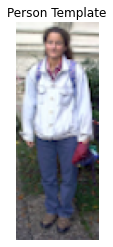

  0%|          | 0/15 [00:00<?, ?it/s]

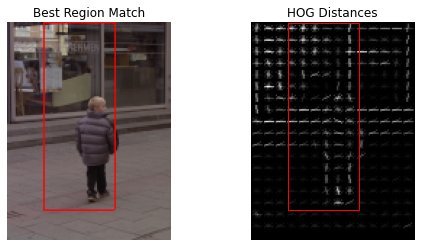

  7%|▋         | 1/15 [00:05<01:10,  5.00s/it]

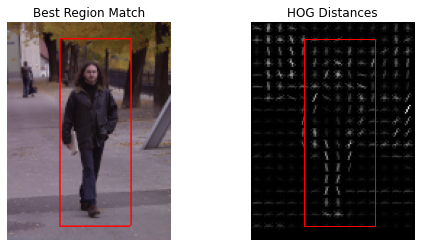

 13%|█▎        | 2/15 [00:09<01:00,  4.64s/it]

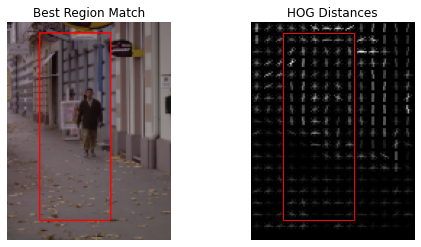

 20%|██        | 3/15 [00:13<00:50,  4.25s/it]

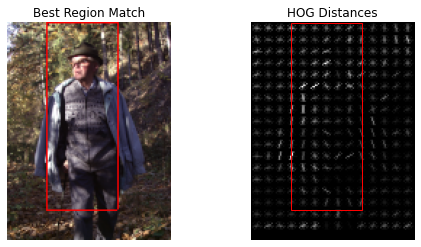

 27%|██▋       | 4/15 [00:17<00:44,  4.08s/it]

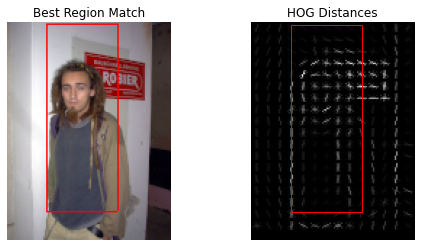

 33%|███▎      | 5/15 [00:21<00:44,  4.40s/it]

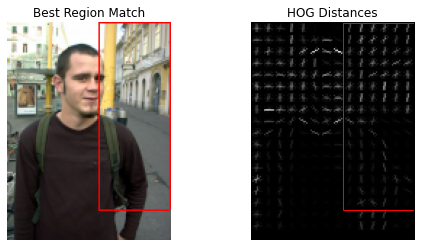

 40%|████      | 6/15 [00:26<00:40,  4.53s/it]

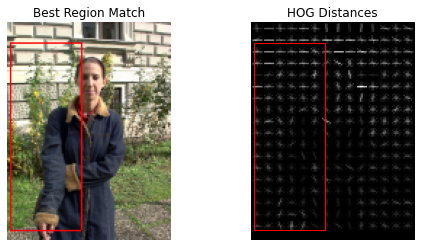

 47%|████▋     | 7/15 [00:31<00:36,  4.57s/it]

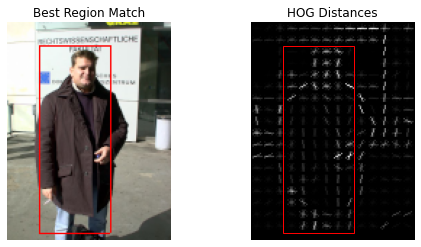

 53%|█████▎    | 8/15 [00:35<00:31,  4.49s/it]

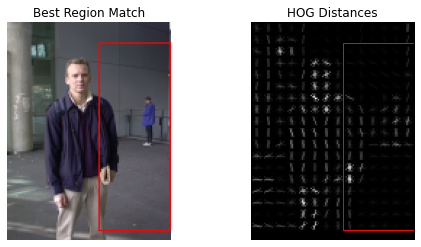

 60%|██████    | 9/15 [00:39<00:25,  4.33s/it]

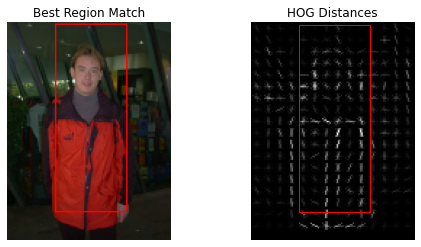

 67%|██████▋   | 10/15 [00:43<00:21,  4.26s/it]

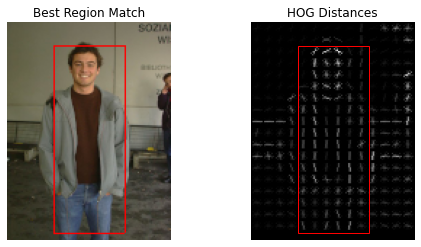

 73%|███████▎  | 11/15 [00:47<00:16,  4.18s/it]

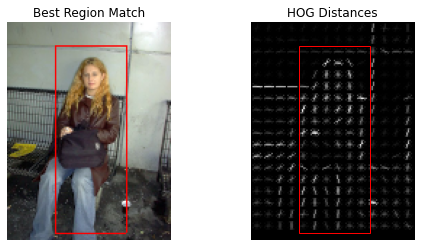

 80%|████████  | 12/15 [00:51<00:12,  4.13s/it]

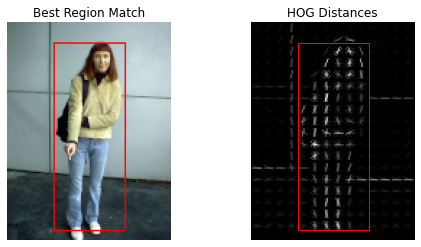

 87%|████████▋ | 13/15 [00:55<00:08,  4.12s/it]

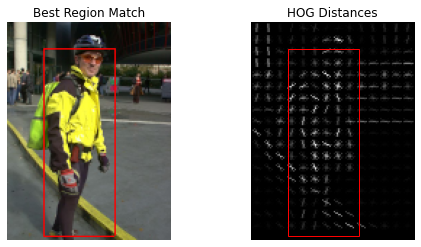

 93%|█████████▎| 14/15 [01:00<00:04,  4.17s/it]

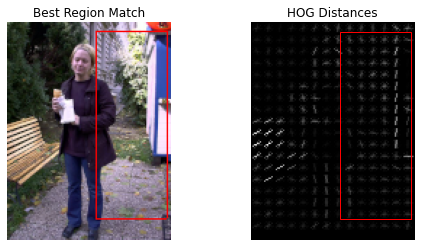

100%|██████████| 15/15 [01:04<00:00,  4.28s/it]


In [24]:
hog_comparison(test_person_images, person_template, 'Person')

What is the dimension of your HOG descriptor? Explain it.

In [ ]:
# Your solution here

Count on how many images were the persons detected correctly and discuss the failures.
What do you think can be the reasons for the failures?

In [ ]:
# Your solution here

Test several values of the parameters (``orientations``, ``pixels_per_cell``, ``cells_per_block``) to show which are the optimal values for the person detection problem.

In [ ]:
# Your solution here

Comment the object detection process:
* Please, explain briefly the algorithm, including advantages and disadvantage
* Do you see any advantages of the HOG-based object detector compared to the template-based object detection? (The answer should be up to 10-15 lines).

In [ ]:
# Your solution here

# 3 ORB feature detector and binary descriptor

Let us consider the problem of feature extraction that contains two subproblems: 
- feature location, 
- image feature description.

Let us focus on ORB, an approximation of SIFT method, and analyse if ORB is  scale and rotation invariant, a property that is very important for real-time applications.

**Hint:** `ORB` is a function within the module `skimage.feature`
                             
**Help**: We suggest to have a look at the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) how to compute the ORB descriptors and find the descriptors match. You can use the function match_descriptors from `skimage.feature` module in order to compute and show the similar detected descriptors of the given images. 

**3.1** Detect the censure in the image `starbucks4.jpg`. Analyze and discuss the effect of different values of the parameters in censure function.

In [92]:
from skimage.feature import CENSURE, ORB

def do_censure(image, title, ax, min_scale=1, max_scale=7, mode='DoB', non_max_threshold=0.15, line_threshold=10):
    censure = CENSURE(min_scale, max_scale, mode, non_max_threshold, line_threshold)
    censure.detect(image)
    ax.imshow(image)
    ax.axis('off')
    ax.scatter(censure.keypoints[:, 1], censure.keypoints[:, 0], 2 ** censure.scales, facecolors='none', edgecolors='r')
    ax.set_title(title)

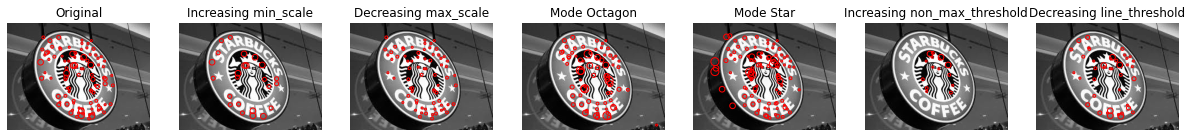

In [96]:
starbucks4 = io.imread('images/starbucks4.jpg', as_gray=True)

fig, axs = plt.subplots(ncols=7, figsize=(21, 5))

do_censure(starbucks4, 'Original', axs[0])

# Increasing min_scale discards the points with radius smaller than min_scale
do_censure(starbucks4, 'Increasing min_scale', axs[1], min_scale=3)

# Decreasing max_scale discards the points with radius bigger than max_scale
do_censure(starbucks4, 'Decreasing max_scale', axs[2], max_scale=4)

# Uses an octagon mask instead of a box mask to obtain better features 
# (sacrifices performance, according to the manual)
do_censure(starbucks4, 'Mode Octagon', axs[3], mode='Octagon')

# Uses a star mask instread of a box mask to obtain better features 
# (sacrifices even more performance)
do_censure(starbucks4, 'Mode Star', axs[4], mode='STAR')

# Uses bigger magnitudes to determine the key points (lower thresholds mean more key points)
do_censure(starbucks4, 'Increasing non_max_threshold', axs[5], non_max_threshold=0.4)

# Lower values of line_threshold makes key points less frequent because they appear
# mainly in corners (i.e 90º angles) and ignores features from curves.
do_censure(starbucks4, 'Decreasing line_threshold', axs[6], line_threshold=5)
plt.show()

**3.2** Detect the correspondences between the model image `starbucks.jpg` with the scene image `starbucks4.jpg`. You can adapt the code from the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) above. 

Define a function get_ORB implementing the algorithm in order to be able to apply it on different images. Comment the code in detail.

**Hint: If the function plot_matches() gives you an error you can use the plot_matches_aux() at the end of this file.**

Analyze and discuss the effect of different values of the parameter `max_ratio` in the match_descriptors function.


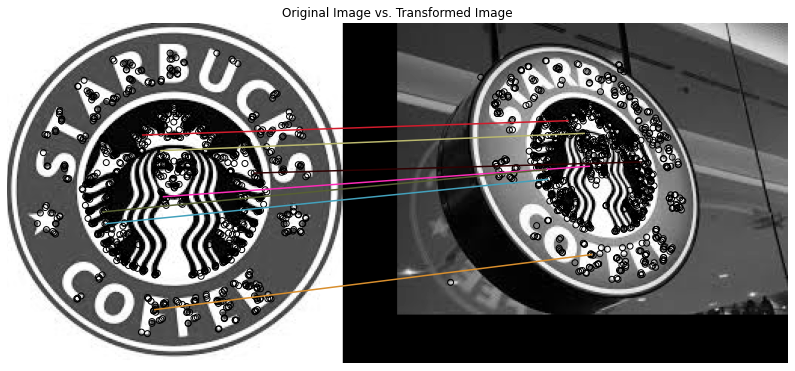

In [174]:
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.color import rgb2gray

'''
max_ratio is used to take into account the key points which have a certain value 
of confidence. A lower value of max_ratio will make the result match fewer key 
points, because it will discard ambiguous matchings (different points with similar 
confidence), while a higher value will match more. In our case values
close to 0.9 already match a very small number of key points (a max_ratio of 1 will
try to match all the key points). This means ORB is not very good (with default params) 
at matching the starbucks images. 
'''

starbucks = io.imread('images/starbucks.jpg', as_gray=True)

def get_ORB(image1, image2):

    descriptor_extractor = ORB(n_keypoints=800)

    descriptor_extractor.detect_and_extract(image1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(image2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.8)

    fig, ax = plt.subplots(figsize=(14, 10))
    plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12)
    ax.axis('off')
    ax.set_title("Original Image vs. Transformed Image")

    plt.show()

get_ORB(starbucks, starbucks4)

Repeate the experiment comparing the `starbucks.jpg` image as a model, and showing its matches to all Starbucks images, sorting them based on their similarity to the model. Comment when does the algorithm work better. 

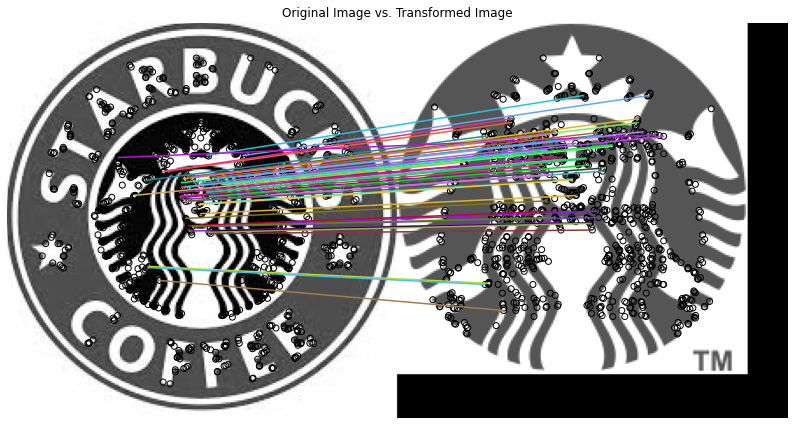

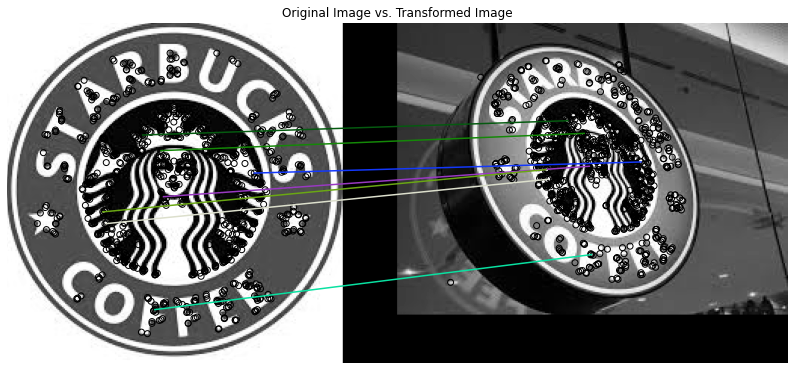

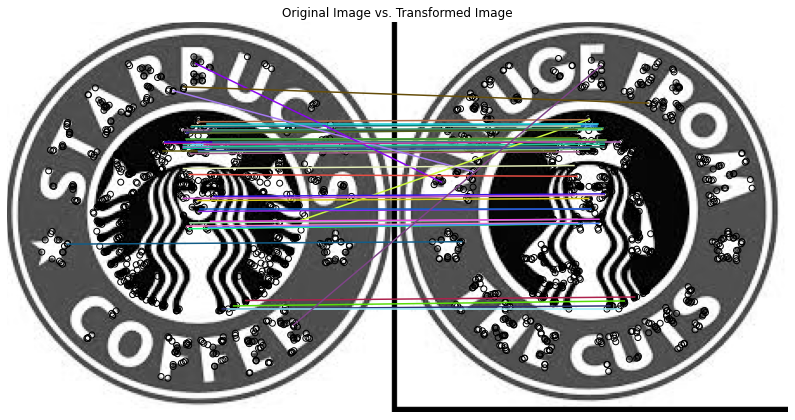

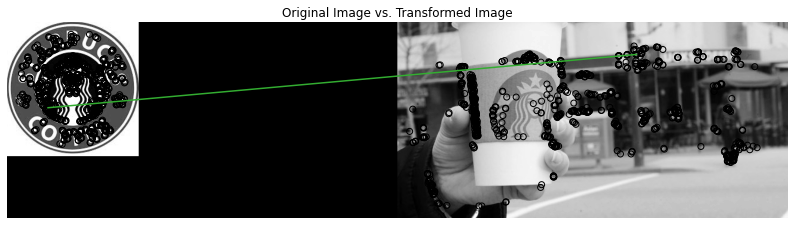

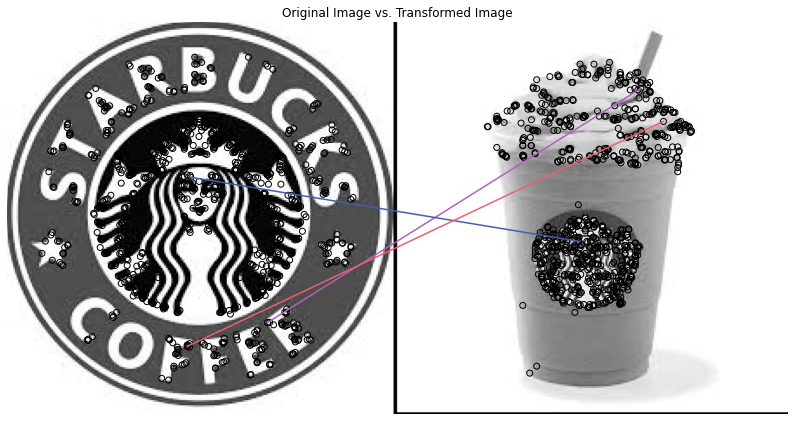

In [175]:
starbucks2 = io.imread('images/starbucks2.png', as_gray=True)
starbucks5 = io.imread('images/starbucks5.png', as_gray=True)
starbucks6 = io.imread('images/starbucks6.jpg', as_gray=True)
starbucksCup = io.imread('images/starbucksCup.jpg', as_gray=True)

compare = [starbucks2, starbucks4, starbucks5, starbucks6, starbucksCup]

for image2 in compare:
    get_ORB(starbucks, image2)

**3.3** Repeate the experiment: 
- Changing the orientation of the model image by rotating it and comparing it with its original version. Help: you can use the rotate() function from skimage.transform 
- Change the scale and orientation of the scene image and compare it with the model image.

**Help:** To do so, you can use the function given below as example:

```
import transform as tf
rotationdegrees = 180
img_rotated = tf.rotate(image2transform, rotationdegrees)
```

or

```
tform = tf.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
img_transformed = tf.warp(image2transform, tform)
```

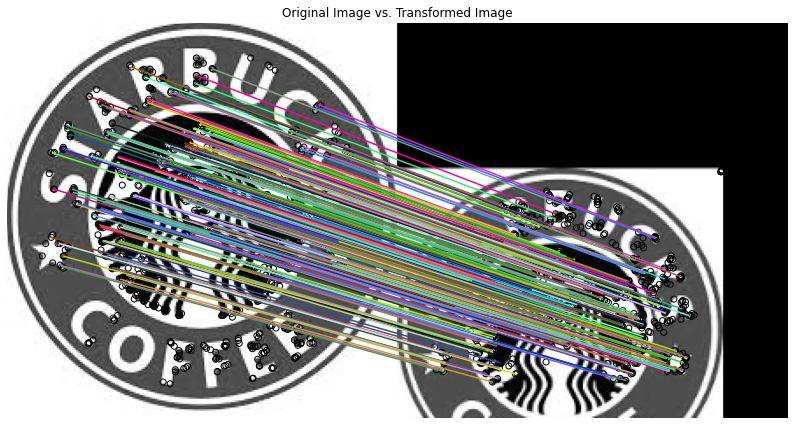

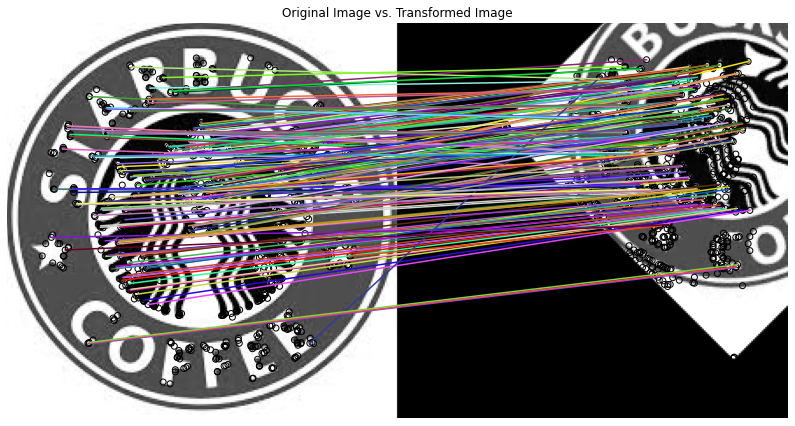

RuntimeError: ORB found no features. Try passing in an image containing greater intensity contrasts between adjacent pixels.

In [177]:
from skimage.transform import AffineTransform, warp

for angle in range(0, 181, 45):
    tfrm = AffineTransform(scale=(1.2, 1.2), rotation=np.deg2rad(angle), translation=(0, -100))
    get_ORB(starbucks, warp(starbucks, tfrm))

**(Optional)** Repeat the experiment (3.1 to 3.3) with a new group of images. You could use Coca-Cola advertisements or from another famous brand, easily to find on internet.


In [ ]:
# Your solution here

**3.4** Analysis of the applied techniques and results

- What are the advantages of the ORB object detection with respect to the HOG and template object detector?

- What would happen if you analyse an image that does not contain the Starbucks logo? 

- Could you think of ways of defining a quality measure for the correspondance between two images? (no need of implementing it) 

In [ ]:
# Your solution here

### Appendix

In [ ]:
# In case the plot_matches() function gives you some problems, you can use the following one:

from skimage.util import img_as_float
import numpy as np

def plot_matches_aux(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1 = img_as_float(image1)
    image2 = img_as_float(image2)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]),
                '-', color=color)